# Introduction 

## Tổng quan về bộ dữ liệu 

- Bộ dữ liệu này là sự kết hợp của ba nguồn: figshare, SARTAJ dataset, và Br35H. Nó bao gồm 7.023 hình ảnh MRI não người, được phân loại thành 4 nhóm chính: glioma, meningioma, no tumor (không có khối u), và pituitary.
- Tổng số lượng hình ảnh: 7.023 ảnh MRI não người, chia thành 4 nhóm chính:
    1. **Glioma**: U ác tính trong tế bào thần kinh đệm.
    2. **Meningioma**: U lành tính phát triển từ màng não.
    3. **No Tumor**: Ảnh quét não bình thường, không có khối u (lấy từ Br35H).
    4. **Pituitary**: U tuyến yên (có thể lành hoặc ác tính).
 
- Hình ảnh trong bộ dữ liệu có kích thước khác nhau. Để đạt hiệu quả tốt hơn, cần:
  1. Tiền xử lý: Loại bỏ viền dư thừa.
  2. Resize hình ảnh về cùng kích thước trước khi huấn luyện mô hình.
- Mục tiêu: Ứng dụng bộ dữ liệu trong việc phân loại ảnh theo loại (glioma, meningioma, pituitary, no tumor) và cấp độ ác tính.

- Kích thước dữ liệu (bao gồm 2 tập Training + Testing):
- **Tập training** : glioma 
132files, meningioma a

files, iles
n umor
files, 5 files
 tuitary

- **Tập Testing**: glioma 300 files, meningioma 300 files, notumor 405 files, pituitary 300 files
300 files
1457 files

# Data Preprocessing

## Get Data

In [1]:
!pip install -q lightning onnxruntime

In [2]:
import torch 
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import lightning as pl

In [3]:
DATA_PATH = '/kaggle/input/brain-tumor-mri-dataset'
TRAIN_PATH = DATA_PATH + '/Training'
TEST_PATH = DATA_PATH + '/Testing'

## EDA

- Phân bố các nhãn dữ liệu 

In [4]:
def plot_pie(counts): 
    plt.figure(figsize=(8, 8))
    plt.pie(
        list(counts.values()), 
        labels=list(counts.keys()), 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=plt.cm.Paired.colors
    )
    plt.title("Phân bố các trường dữ liệu")
    plt.show()
    

In [5]:
import os 

def count_data(path: str): 
    classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
    
    counts = {}

    for root, dirs, files in os.walk(path): 
        name = str(root.split("/")[-1]) 
        
        if files != [] and name in classes: 
            counts[name] = len(files)
    return counts 

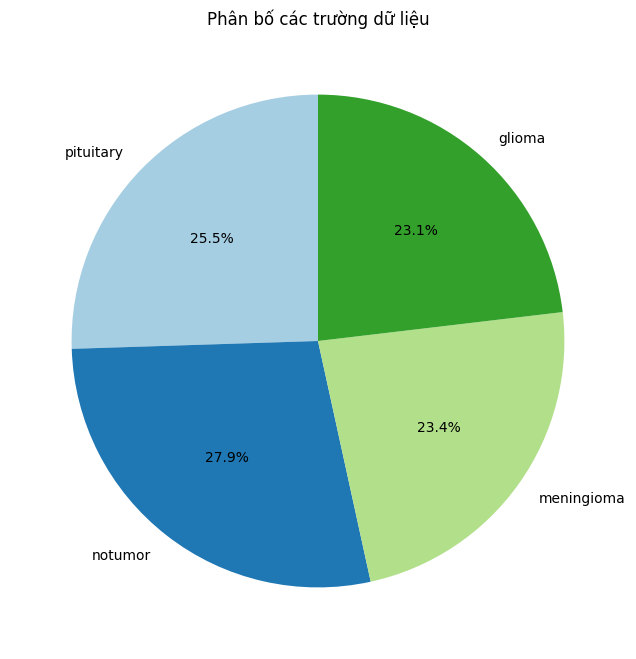

In [6]:
count_training = count_data(TRAIN_PATH)
plot_pie(count_training)

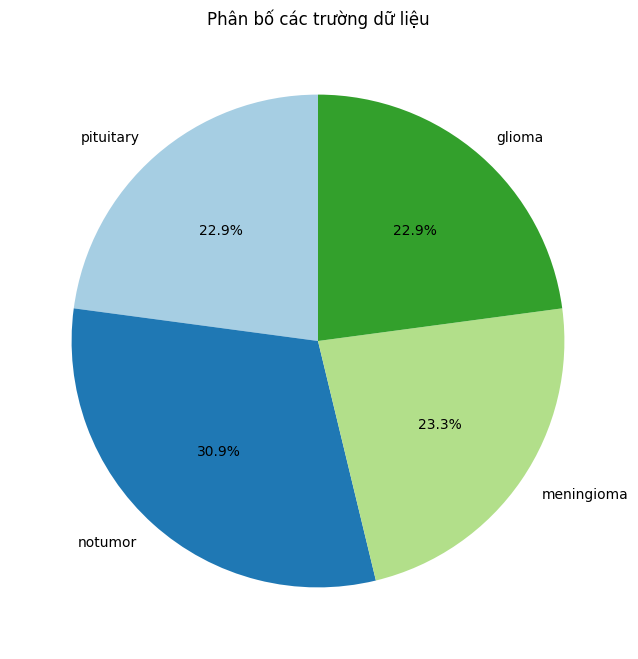

In [7]:
count_testing = count_data(TEST_PATH)
plot_pie(count_testing)

=> Phân bố dữ liệu đồng đều AttributeError

- Kích thước ảnh 

In [8]:
from PIL import Image

def get_image_sizes(folder_path):
    image_sizes = []  
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        width, height = img.size
                        image_sizes.append((width, height))
                except Exception as e:
                    print(f"Lỗi đọc ảnh {file_path}: {e}")
    return image_sizes

In [9]:
def plot_img_size(image_sizes, data_name): 
    widths, heights = zip(*image_sizes)  
    plt.figure(figsize=(8, 6))
    plt.scatter(widths, heights, alpha=0.6, edgecolor='k')
    plt.title(f'Kích thước ảnh (Width x Height) của {data_name}', fontsize=14)
    plt.xlabel('Chiều rộng (Width)', fontsize=12)
    plt.ylabel('Chiều cao (Height)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

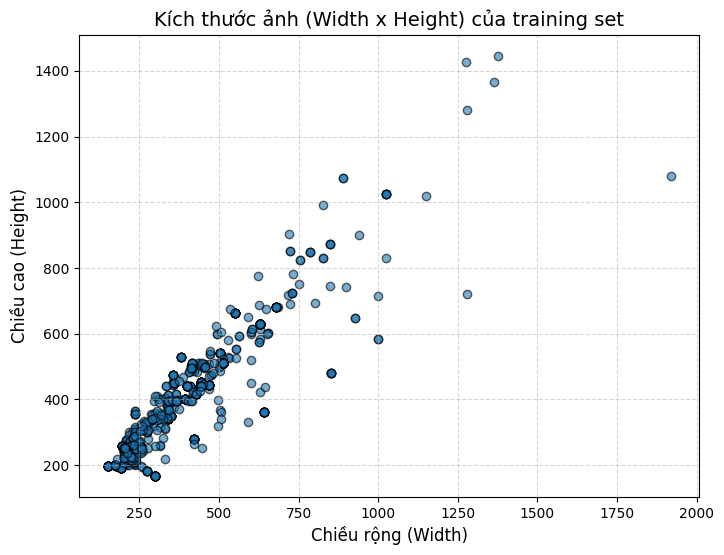

In [10]:
training_image_sizes = get_image_sizes(TRAIN_PATH)
plot_img_size(training_image_sizes, "training set")

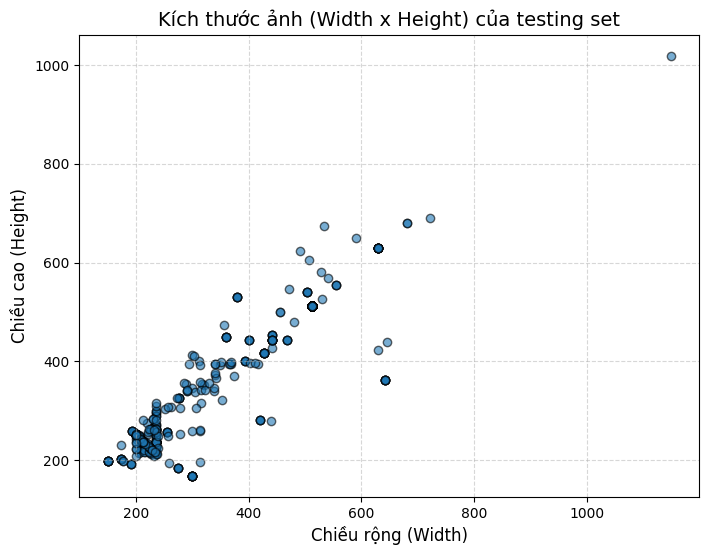

In [11]:
testing_image_sizes = get_image_sizes(TEST_PATH)
plot_img_size(testing_image_sizes, "testing set")

- Visualize một số điểm dữ liệu 

In [12]:
import random

def get_category_images(folder_path):
    category_images = {}
    for root, _, files in os.walk(folder_path):
        category = os.path.basename(root)
        if category not in category_images:
            category_images[category] = []
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                category_images[category].append(os.path.join(root, file))
    return category_images


In [13]:
def plot_random_images(category_images):
    selected_images = {}

    for category, images in category_images.items():
        if images: 
            selected_images[category] = random.choice(images)
    
    plt.figure(figsize=(12, 8))
    for i, (category, image_path) in enumerate(selected_images.items(), start=1):
        try:
            img = Image.open(image_path)
            plt.subplot(2, 2, i)
            plt.imshow(img)
            plt.title(category)
            plt.axis('off')
        except Exception as e:
            print(f"Không thể mở ảnh {image_path}: {e}")
    plt.tight_layout()
    plt.show()

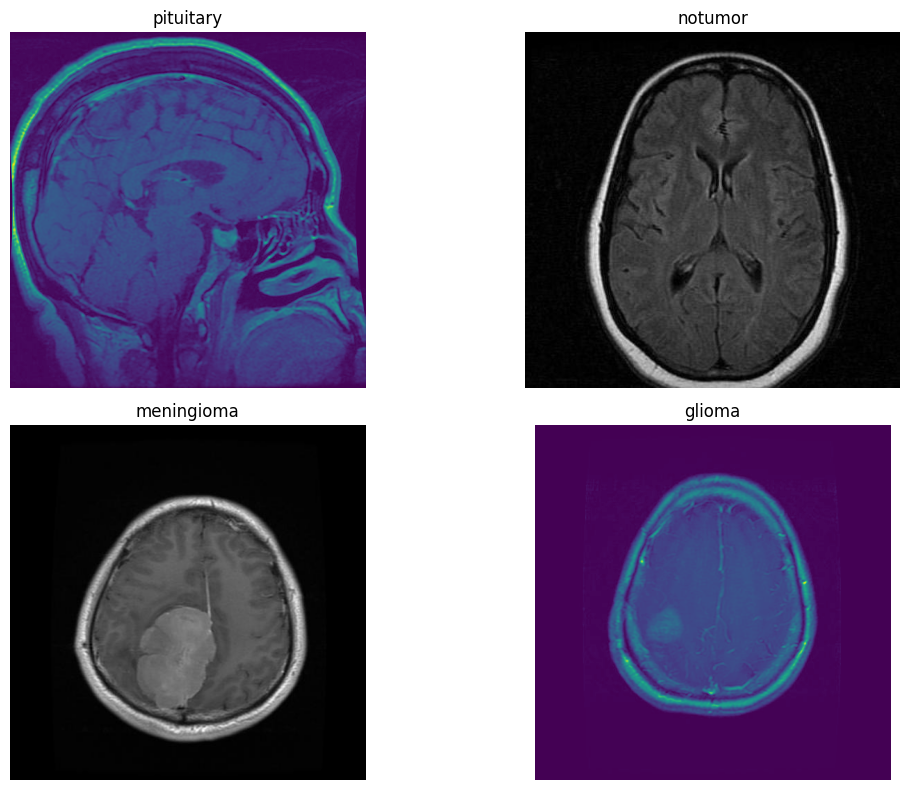

In [14]:
category_images = get_category_images(TRAIN_PATH)
plot_random_images(category_images)

## Data Transform

In [15]:
def transform_data_to_dict(folder_path):
    image_dict = {} 
    index = 0

    for root, _, files in os.walk(folder_path):
        label = os.path.basename(root)
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                file_path = os.path.join(root, file)
                image_dict[index] = {'path': file_path, 'label': label}
                index += 1
    return image_dict

In [16]:
train_dict = transform_data_to_dict(TRAIN_PATH)
test_dict = transform_data_to_dict(TEST_PATH)

In [17]:
len(train_dict)

5712

In [18]:
len(test_dict)

1311

## Dataset 

In [19]:
# visualize 
from torch.utils.data import Dataset, DataLoader

class BrainTumourDataset(Dataset): 

    def __init__(self, data_dir: str, transform = None): 
        self.data_dict = transform_data_to_dict(data_dir)
        self.transform = transform 
        self.labels =  ['glioma', 'meningioma', 'notumor', 'pituitary']
        

    def __getitem__(self, idx):
        datapoint = self.data_dict[idx]
        path = datapoint['path']
        label = self.labels.index(datapoint['label']) 

        img = Image.open(path).convert('RGB')
        if self.transform : img = self.transform(img)
        return img, label
            
        
    def __len__(self): 
        return len(self.data_dict)
    

In [20]:
# define transform 
from torchvision import transforms 

data_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.RandomVerticalFlip(),
                                     transforms.RandomAdjustSharpness(sharpness_factor=1.5),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ColorJitter(),
                                     transforms.Resize((224,224))])

In [21]:
# define data loader 
import lightning as pl 


class BrainTumorDatamodule(pl.LightningDataModule): 

    def __init__(self, train_dir: str, test_dir: str, transform):
        self.train_dir = train_dir
        self.test_dir = test_dir 
        self.transform = transform 

    def setup(self, stage = None): 
        self.train_dataset = BrainTumourDataset(self.train_dir, self.transform)
        self.val_dataset = BrainTumourDataset(self.test_dir, self.transform)

    def train_dataloader(self): 
        return DataLoader(self.train_dataset, shuffle=True, batch_size= 64, num_workers=4)

    def val_dataloader(self): 
        return DataLoader(self.val_dataset, shuffle=True, batch_size=64, num_workers=4)




In [22]:
datamodule = BrainTumorDatamodule(TRAIN_PATH, TEST_PATH, data_transform)

datamodule.setup()

train_loader = datamodule.train_dataloader()

In [23]:
for batch_idx, (inputs, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx+1}:")
    print(f"Inputs:\n{inputs}")
    print(f"Labels:\n{labels}")
    print("-" * 30)
    break 

Batch 1:
Inputs:
tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0008, 0.0008, 0.0008],
          [0.0028, 0.0028, 0.0028,  ..., 0.0065, 0.0065, 0.0065],
          [0.0085, 0.0085, 0.0085,  ..., 0.0124, 0.0124, 0.0124],
          ...,
          [0.0049, 0.0049, 0.0049,  ..., 0.0070, 0.0070, 0.0070],
          [0.0004, 0.0004, 0.0004,  ..., 0.0028, 0.0028, 0.0028],
          [0.0031, 0.0031, 0.0031,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0008, 0.0008, 0.0008],
          [0.0028, 0.0028, 0.0028,  ..., 0.0065, 0.0065, 0.0065],
          [0.0085, 0.0085, 0.0085,  ..., 0.0124, 0.0124, 0.0124],
          ...,
          [0.0049, 0.0049, 0.0049,  ..., 0.0070, 0.0070, 0.0070],
          [0.0004, 0.0004, 0.0004,  ..., 0.0028, 0.0028, 0.0028],
          [0.0031, 0.0031, 0.0031,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0008, 0.0008, 0.0008],
          [0.0028, 0.0028, 0.0028,  ..., 0.0065, 0.0065, 0.0065],
          [0.0085, 0.0085

In [26]:
image_tensor = datamodule.train_dataset[0][0]
label =  datamodule.train_dataset.labels[datamodule.train_dataset[0][1]]

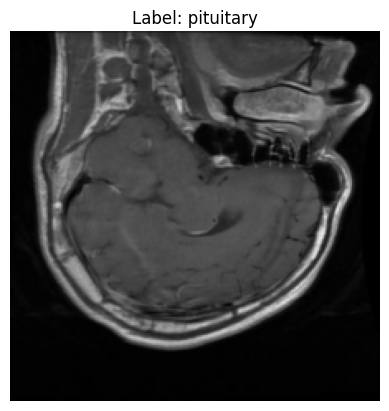

In [27]:

image = image_tensor.permute(1, 2, 0).numpy()

# Hiển thị ảnh bằng matplotlib
plt.imshow(image)
plt.axis('off')  # Tắt hiển thị trục
plt.title(f"Label: {label}")
plt.show()